In [13]:
import s3fs
import pyarrow.parquet as pq
import pyarrow as pa
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import duckdb

from datetime import datetime

In [14]:
plt.style.use('ggplot')

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "https://minio.minio-tenant",
        "aws_access_key_id": "admin",
        "aws_secret_access_key": "6bd71ace-8866-407a-9bcc-714bc5753f18",
        "verify": "/home/rafael/.certs/dev/rootCA.pem",
    }
)

In [16]:
# select preciptation data from Minas Gerais state

filters = [('adm1', '=', 'BRA.13_1'), ('element', '=', 'PRCP')]
pa_prcp = pq.read_table("dutrajardim-fi/tables/ghcn.parquet", filters=filters, filesystem=fs)
pd_prcp = pa_prcp.to_pandas()
pd_prcp['date'] = pd_prcp['datetime'].dt.strftime('%Y-%m-%d')
pd_prcp['month_week'] = pd_prcp['datetime'].dt.strftime('%m-%W')

In [12]:
arrow_table = pq.read_table("dutrajardim-fi/tables/shapes/adm3.parquet", filesystem=fs)
con = duckdb.connect()
con.execute("SELECT COUNT(*) FROM arrow_table").fetchall()[0][0]

10193

In [117]:
# select temperature data from Minas Gerais state

filters = [('adm1', '=', 'BRA.13_1'), ('element', 'in', ['TMAX', 'TMIN', 'TAVG'])]
pa_tempr = pq.read_table("dutrajardim-fi/tables/ghcn.parquet", filters=filters, filesystem=fs)
pd_tempr = pa_tempr.to_pandas()
pd_tempr['date'] = pd_tempr['datetime'].dt.strftime('%Y-%m-%d')
pd_tempr['month_week'] = pd_tempr['datetime'].dt.strftime('%m-%W')

pd_tmax = pd_tempr[pd_tempr['element'] == 'TMAX']
pd_tmin = pd_tempr[pd_tempr['element'] == 'TMIN']
pd_tavg = pd_tempr[pd_tempr['element'] == 'TAVG']

In [6]:
# select stations next to Minas Gerais' administrative areas level 3 (data duplication on adms level 2, 1 and 0)

# filters = [('adm1', '=', 'BRA.13_1'), ('distance', '<', 40000)]
filters = [('adm1', '=', 'BRA.13_1')]
pa_stations = pq.read_table("dutrajardim-fi/tables/stations.parquet", filters=filters, filesystem=fs, columns=['geometry', 'id', 'adm2', 'adm3'])
pd_stations = pa_stations.to_pandas()
pd_stations = pd_stations.groupby('id').first().reset_index()

In [9]:
# select admistrative areas level 2 and 3 from Minas Gerais

filters = [('adm1', '=', 'BRA.13_1')]
pa_shapes3 = pa.parquet.read_table("dutrajardim-fi/tables/shapes/adm3.parquet", filters=filters, filesystem=fs)
pd_shapes3 = pa_shapes3.to_pandas()

pa_shapes2 = pa.parquet.read_table("dutrajardim-fi/tables/shapes/adm2.parquet", filters=filters, filesystem=fs)
pd_shapes2 = pa_shapes2.to_pandas()

gpd_shapes2 = gp.GeoDataFrame(
    pd_shapes2[["id", "name"]],
    geometry=gp.GeoSeries.from_wkt(pd_shapes2['geometry']),
    crs=4326
)
gpd_shapes2 = gpd_shapes2.to_crs(3857)

gpd_shapes3 = gp.GeoDataFrame(
    pd_shapes3[["id", "name"]],
    geometry=gp.GeoSeries.from_wkt(pd_shapes3['geometry']),
    crs=4326
)
gpd_shapes3 = gpd_shapes3.to_crs(3857)

In [10]:
gpd_stations = gp.GeoDataFrame(
    pd_stations[['id', 'adm2', 'adm3']],
    geometry=gp.GeoSeries.from_wkt(pd_stations['geometry']),
    crs=3857
)

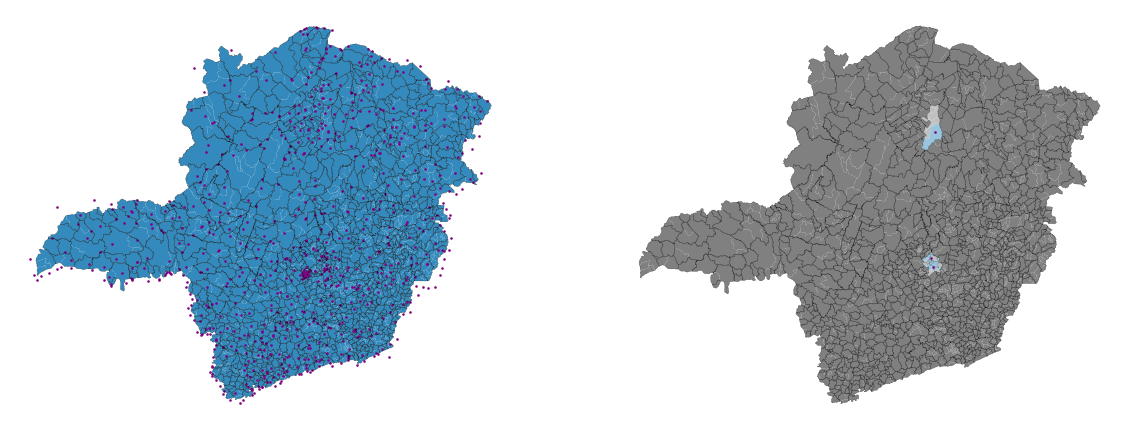

In [11]:
nrows, ncols = 1, 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

adm3_covered = pa_stations.to_pandas()['adm3'].unique()

gpd_shapes3[gpd_shapes3['id'].isin(adm3_covered)].plot(ax=axs[0])
# gpd_shapes3[~gpd_shapes3['id'].isin(adm3_covered)].plot(ax=axs[0], color='#ccc')
gpd_stations.plot(ax=axs[0], color='purple', markersize=4)

gpd_shapes2.plot(ax=axs[0], edgecolor='black', linewidth=.2, facecolor='none')


# chart 2
amd2_covered = pa_stations.to_pandas()['adm2'].unique()
gpd_shapes3[~gpd_shapes3['id'].isin(pd_prcp['adm3'].unique())].plot(ax=axs[1], color='gray')
gpd_shapes3[gpd_shapes3['id'].isin(pd_prcp['adm3'].unique())].plot(ax=axs[1])
gpd_shapes2[~gpd_shapes2['id'].isin(pd_prcp['adm2'].unique())].plot(ax=axs[1], edgecolor='black', linewidth=.2, facecolor='none')
gpd_shapes2[gpd_shapes2['id'].isin(pd_prcp['adm2'].unique())].plot(ax=axs[1], edgecolor='black', linewidth=.2, facecolor='white', alpha=.5)

gpd_stations[gpd_stations['id'].isin(pd_prcp['station'].unique())].plot(ax=axs[1], color='purple', markersize=4)

for i in range(nrows * ncols):
    axs[i].set_axis_off()

plt.show()

In [12]:
pd_shapes2[pd_shapes2['id'].isin(pd_prcp['adm2'].unique())][['id', 'name']].set_index('id')

,name
id,
BRA.13.65_1,Belo Horizonte
BRA.13.199_1,Confins
BRA.13.433_1,Lagoa Santa
BRA.13.504_1,Montes Claros
BRA.13.580_1,Pedro Leopoldo
BRA.13.640_1,Ribeirão das Neves
BRA.13.662_1,Sabará
BRA.13.680_1,Santa Luzia
BRA.13.743_1,São José da Lapa


In [99]:
pdgrp_prcp = pd_prcp \
    .groupby(['adm2', 'year', 'month_week']).agg(
        datetime=pd.NamedAgg('datetime', 'last'),
        number_of_stations=pd.NamedAgg('station', 'nunique'),
        mean_value=pd.NamedAgg('value', 'mean'),
        # mean_value=pd.NamedAgg('value', lambda x: x.sum() / 7),
        sum_value=pd.NamedAgg('value', 'sum'),
        days_of_data=pd.NamedAgg('date', 'nunique')
    )

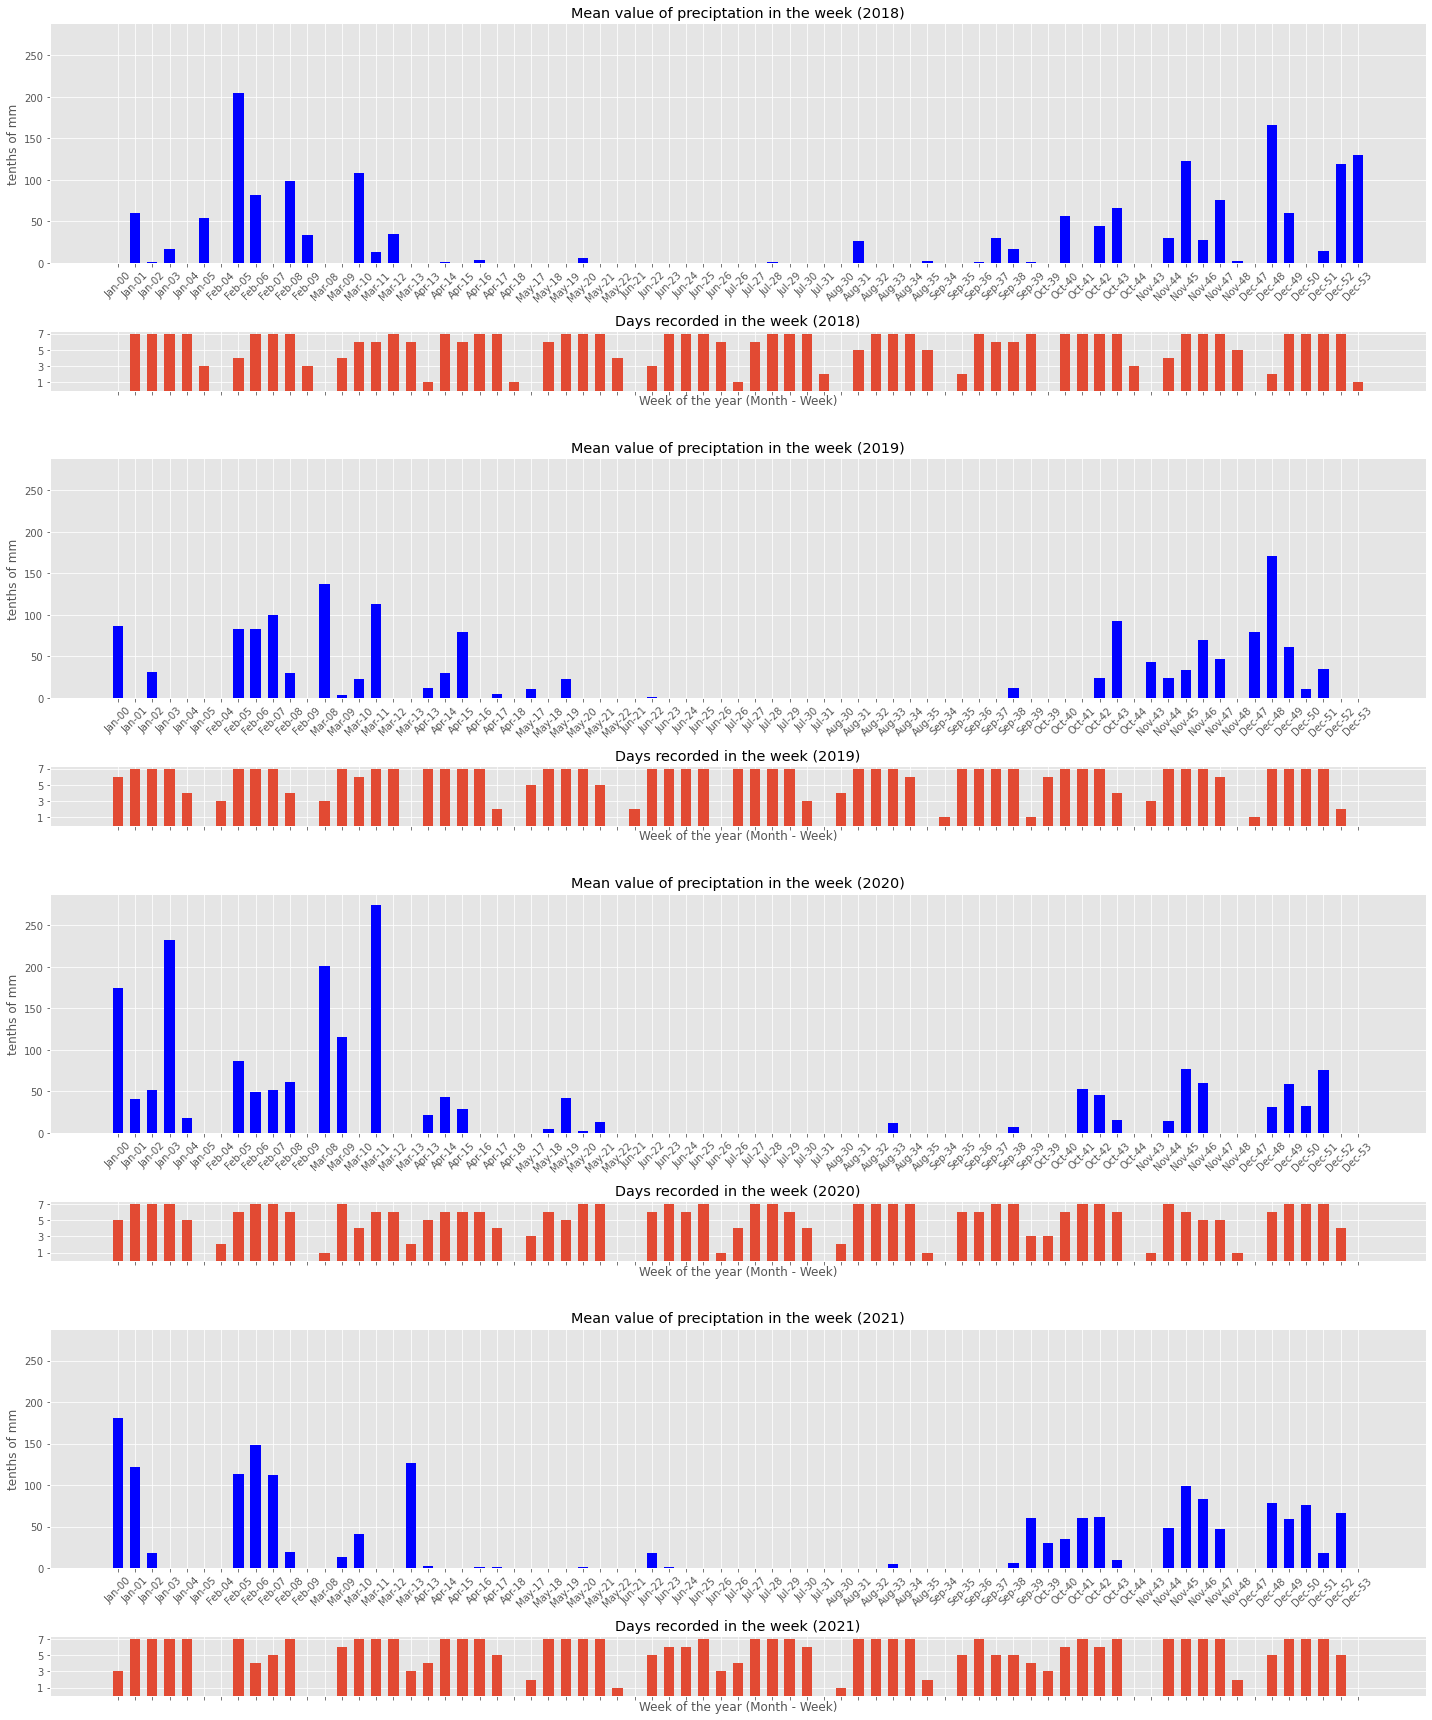

In [100]:
years = [2018, 2019, 2020, 2021]
adm2_id = 'BRA.13.65_1'
nrows = len(years) * 2 

fig, axs = plt.subplots(
    ncols=1, 
    nrows=nrows, 
    figsize=(20, nrows*3), 
    sharex=True,
    gridspec_kw={'height_ratios': [1 if x % 2 else 4 for x in range(nrows)]} # height ratios [4, 1, 4, 1 ... 4, 1]
)

axs[0].get_shared_y_axes().join(*[axs[x] for x in range(0, len(years) * 2, 2)])
axs[1].get_shared_y_axes().join(*[axs[x] for x in range(1, len(years) * 2, 2)])

width = .6

def x_fmt_func(labels):
    return ticker.FuncFormatter(lambda x, y: datetime.strptime(labels[x][:2], "%m").strftime("%b") + labels[x][2:])


for key, year in enumerate(years):
    i1, i2 = key * 2, key * 2 + 1

    data_df = pdgrp_prcp.loc[(adm2_id, year), 'mean_value']
    
    data_x = np.arange(len(data_df.index))
    data_y = data_df.values

    axs[i1].bar(data_x, data_y, width=width, color='blue')

    axs[i1].set_ylabel('tenths of mm')
    axs[i1].set_title('Mean value of preciptation in the week (%s)' % year)
    axs[i1].xaxis.set_tick_params(labelbottom=True, rotation=45)
    
    data_df = pdgrp_prcp.loc[(adm2_id, year), 'days_of_data']

    data_x = np.arange(len(data_df.index))
    data_y = data_df.values

    axs[i2].bar(data_x, data_y, width=width)

    axs[i2].set_xticks(data_x)
    axs[i2].set_yticks(range(1, 8, 2))
    axs[i2].xaxis.set_major_formatter(x_fmt_func(data_df.index))
    axs[i2].set_title('Days recorded in the week (%s)' % year)
    axs[i2].set_xlabel('Week of the year (Month - Week)')
    axs[i2].xaxis.set_tick_params(labelbottom=False)

# axs.set_xticks(xticks + width / (2 / 2 ** (number_of_bars - 2)))

plt.tight_layout()
plt.show()

In [169]:
pdgrp_tavg = pd_tavg \
    .groupby(['adm2', 'station', 'year', 'month_week']).agg(
        datetime=('datetime', 'last'),
        number_of_stations=('station', 'nunique'),
        mean_value=('value', 'mean'),
        days_of_data=('date', 'count'),
    )

pdgrp_tavg

datetime  \
adm2         station     year month_week                       
BRA.13.199_1 BR001943012 2018 01-00                      NaT   
                              01-01                      NaT   
                              01-02                      NaT   
                              01-03                      NaT   
                              01-04                      NaT   
...                                                      ...   
BRA.13.845_1 BRM00083587 2021 12-49      2021-12-12 03:00:00   
                              12-50      2021-12-19 03:00:00   
                              12-51      2021-12-26 03:00:00   
                              12-52      2021-12-31 03:00:00   
                              12-53                      NaT   

                                          number_of_stations  mean_value  \
adm2         station     year month_week                                   
BRA.13.199_1 BR001943012 2018 01-00                        0         NaN   
                              01-01                        0         NaN   
                              01-02                        0         NaN   
                              01-03                        0         NaN   
                              01-04                        0         NaN   
...                                                      ...         ...   
BRA.13.845_1 BRM00083587 2021 12-49                        1  219.000000   
                              12-50                        1  226.285714   
                              12-51                        1  223.428571   
                              12-52                        1  221.000000   
                              12-53                        0         NaN   

                                          days_of_data  
adm2         station     year month_week                
BRA.13.199_1 BR001943012 2018 01-00                  0  
                              01-01                  0  
                              01-02                  0  
                              01-03                  0  
                              01-04                  0  
...                                                ...  
BRA.13.845_1 BRM00083587 2021 12-49                  7  
                              12-50                  7  
                              12-51                  7  
                              12-52                  5  
                              12-53                  0  

[12848 rows x 4 columns]

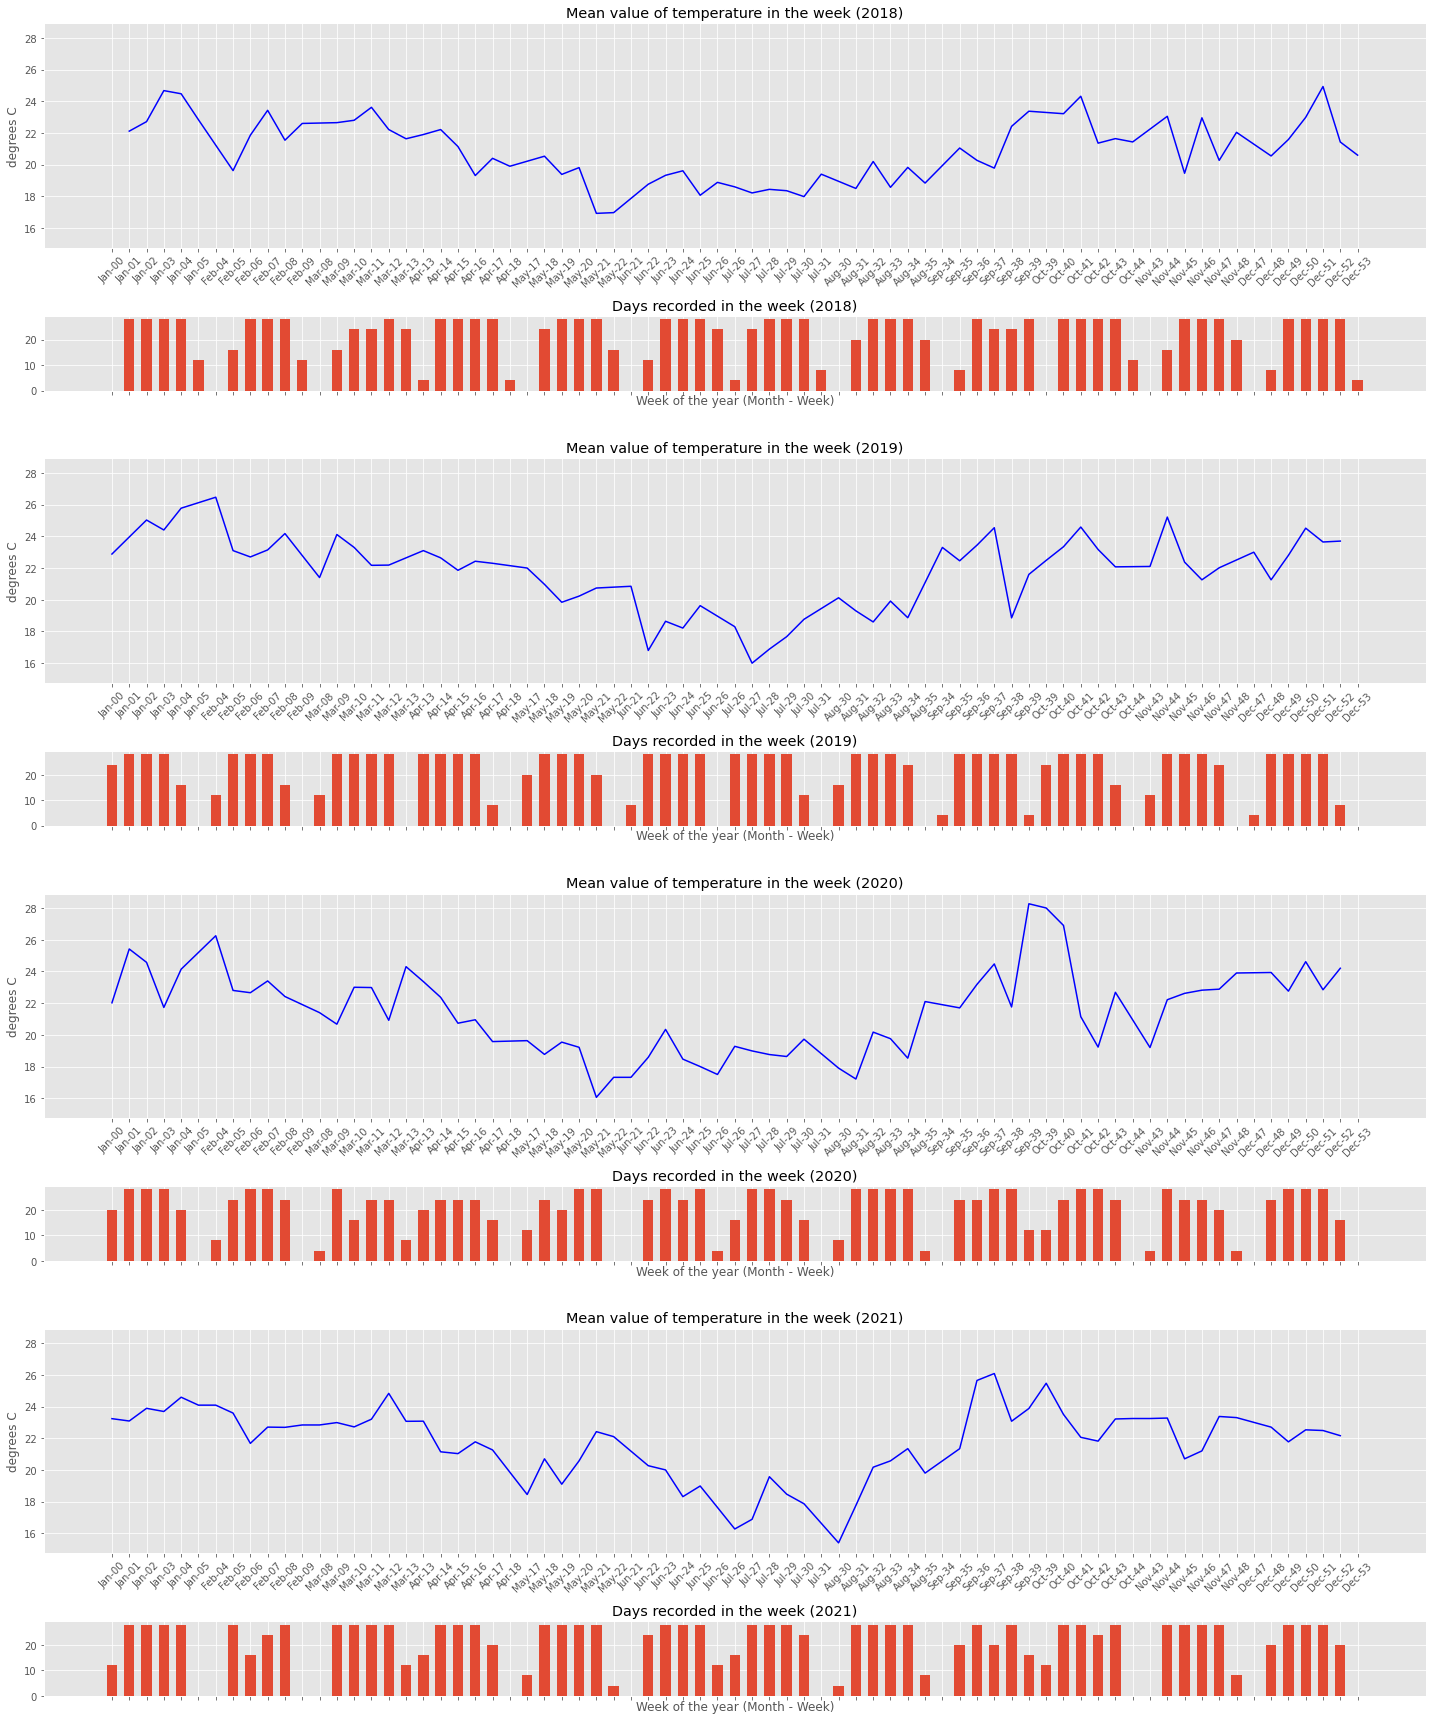

In [166]:
years = [2018, 2019, 2020, 2021]
adm2_id = 'BRA.13.65_1'
nrows = len(years) * 2 

fig, axs = plt.subplots(
    ncols=1, 
    nrows=nrows, 
    figsize=(20, nrows*3), 
    sharex=True,
    gridspec_kw={'height_ratios': [1 if x % 2 else 3 for x in range(nrows)]} # height ratios [4, 1, 4, 1 ... 4, 1]
)

axs[0].get_shared_y_axes().join(*[axs[x] for x in range(0, len(years) * 2, 2)])
axs[1].get_shared_y_axes().join(*[axs[x] for x in range(1, len(years) * 2, 2)])

width = .6

def x_fmt_func(labels):
    return ticker.FuncFormatter(lambda x, y: datetime.strptime(labels[x][:2], "%m").strftime("%b") + labels[x][2:])


for key, year in enumerate(years):
    i1, i2 = key * 2, key * 2 + 1

    data_df = pdgrp_tavg.loc[(adm2_id, year), 'mean_value']
    
    data_x = np.arange(len(data_df.index))
    data_y = ((data_df.fillna(method='ffill') + data_df.fillna(method='bfill')) / 2).values / 10

    axs[i1].plot(data_x, data_y, color='blue')

    axs[i1].set_ylabel('degrees C')
    axs[i1].set_title('Mean value of temperature in the week (%s)' % year)
    axs[i1].xaxis.set_tick_params(labelbottom=True, rotation=45)
    
    data_df = pdgrp_tavg.loc[(adm2_id, year), 'days_of_data']

    data_x = np.arange(len(data_df.index))
    data_y = data_df.values

    axs[i2].bar(data_x, data_y, width=width)

    axs[i2].set_xticks(data_x)
    # axs[i2].set_yticks(range(1, 8, 2))
    axs[i2].xaxis.set_major_formatter(x_fmt_func(data_df.index))
    axs[i2].set_title('Days recorded in the week (%s)' % year)
    axs[i2].set_xlabel('Week of the year (Month - Week)')
    axs[i2].xaxis.set_tick_params(labelbottom=False)


plt.tight_layout()
plt.show()